# LOCALIZATION

In [571]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import pathlib
import sys 
import os
sys.path.append(os.path.abspath("../"))
from ultralytics import YOLO
from typing import List
import math

In [572]:
IMAGE_PATH = pathlib.Path("D:\Data_QR\data\qr_171.jpg")

In [573]:
# Định nghĩa đường dẫn đến mô hình và ảnh
model_path = "D:\\HK5\\CS406\\TestQR3\\exportmodel\\best2.pt"
# image_path = pathlib.Path("D:\\Data_QR\\data\\qr_2039.jpg")

model = YOLO(model_path)

# Dự đoán trên ảnh với các tùy chọn bổ sung
result = model.predict(source=IMAGE_PATH , conf=0.6, save=True, device='cpu')



image 1/1 D:\Data_QR\data\qr_171.jpg: 448x640 1 qr, 76.8ms
Speed: 2.0ms preprocess, 76.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict255


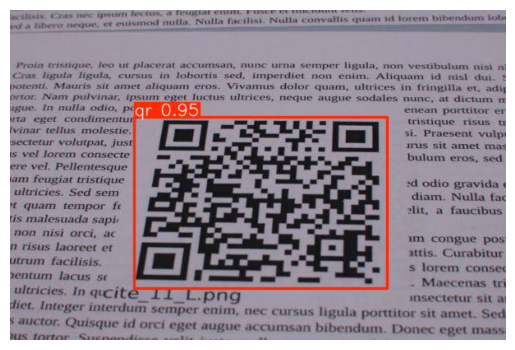

In [574]:
# Hiển thị ảnh (tùy chọn)
img_with_boxes = result[0].plot()
plt.imshow(img_with_boxes)
plt.axis('off')  # Ẩn trục
plt.show()  # Hiển thị ảnh

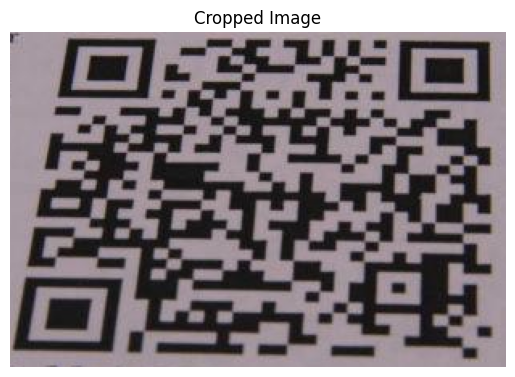

In [575]:
# Đọc ảnh gốc
image = cv2.imread(str(IMAGE_PATH))

# Khởi tạo biến image_crop
image_crop = image

# Lấy bounding box có độ tin cậy cao nhất
for idx, result in enumerate(result):
    if len(result.boxes) > 0:
        # Sắp xếp các box theo độ tin cậy từ cao đến thấp và lấy box đầu tiên
        best_box = sorted(result.boxes, key=lambda box: box.conf[0], reverse=True)[0]
        x_min, y_min, x_max, y_max = map(int, best_box.xyxy[0])  # Lấy tọa độ dạng int

        # Cắt ảnh trong bounding box
        image_crop = image[y_min:y_max, x_min:x_max]
        image_crop = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        # Hiển thị hình ảnh đã cắt
        plt.imshow(image_crop)  # Chuyển đổi màu BGR sang RGB
        plt.axis('off')  # Ẩn trục
        plt.title('Cropped Image')  # Tiêu đề cho hình ảnh
        plt.show()  # Hiển thị cửa sổ
    else:
        print(f"Image {idx + 1}: No bounding box detected.")

# BINARIZE

In [576]:
img_gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
# # Áp dụng Adaptive Threshold
# binary_img = cv2.adaptiveThreshold(
#     img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 55, 3
# )
# binary_img = 255 - binary_img
C = 15

mean_filter = cv2.boxFilter(img_gray, ddepth=-1, ksize=(50,50))

threshold = mean_filter - C

# So sánh từng pixel với ngưỡng
binary_img = np.where(img_gray> threshold, 255, 0).astype(np.uint8)

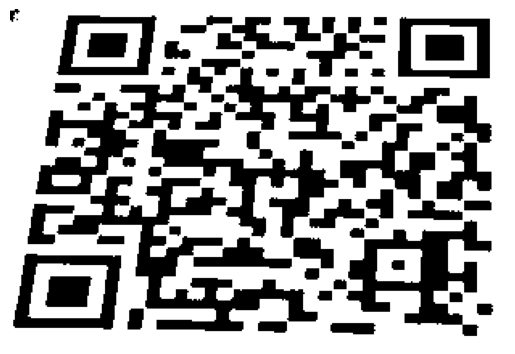

In [577]:
plt.imshow(binary_img, "gray")
plt.axis("off")
plt.show()

In [578]:
print(binary_img.shape)

(208, 308)


# Connected Component Labelling

In [579]:
# Hàm liên thông ngưỡng và 8 hướng
def threshold_connected_components_8way(img, threshold):
    h, w = img.shape
    labels = np.zeros((h, w), dtype=np.int32)
    current_label = 1

    # Duyệt qua từng pixel
    for i in range(h):
        for j in range(w):
            if labels[i, j] == 0:  # Pixel chưa được đánh nhãn
                # Lấy giá trị cường độ của pixel gốc
                base_intensity = img[i, j]
                # Tạo danh sách pixel cần kiểm tra
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    if labels[x, y] == 0:
                        intensity_diff = abs(int(img[x, y]) - int(base_intensity))
                        if intensity_diff <= threshold:
                            labels[x, y] = current_label
                            # Thêm pixel lân cận vào stack (8-liên thông)
                            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                                nx, ny = x + dx, y + dy
                                if 0 <= nx < h and 0 <= ny < w:
                                    stack.append((nx, ny))
                current_label += 1
    return labels

In [580]:
import random
width = binary_img.shape[1]
height = binary_img.shape[0]

min_area = (8 / 177**2) * (width * height)
max_area = (25 / 21**2) * (width * height)
# Hàm liên thông ngưỡng 8 hướng (đã được viết từ trước)
black_mask = (binary_img == 0).astype(np.uint8)
# Liên thông thành phần chỉ xét màu đen
num_labels, labels = cv2.connectedComponents(black_mask, connectivity=8)  # Liên thông 8 hướng

# Khởi tạo ảnh đầu ra
output_image = np.ones((binary_img.shape[0], binary_img.shape[1]), dtype=np.uint8) * 255  # Màu nền là trắng

filtered_centroids = []
filtered_moments = []
bounding_box = []
list_index = []

# Duyệt qua tất cả các nhãn được phát hiện trong ảnh
for label in np.unique(labels):
    if label == 0:  # Bỏ qua nền (nhãn 0)
        continue
    
    print(f"Xử lý thành phần {label}...")

    # Tạo màu ngẫu nhiên cho mỗi thành phần (1 kênh màu)
    color = np.random.randint(0, 256, size=(1,), dtype=np.uint8)  # Màu đơn kênh (grayscale)

    # Áp dụng màu vào thành phần tương ứng trong ảnh đầu ra (Chỉ gán màu vào ảnh đầu ra cho nhãn hiện tại)
    output_image[labels == label] = color

    # Tạo mặt nạ (mask) cho thành phần hiện tại
    mask = (labels == label).astype(np.uint8)

    # Tính toán các thông số moment của thành phần
    moments = cv2.moments(mask)

    if moments['m00'] >= min_area and moments['m00'] <= max_area:  # Kiểm tra điều kiện m00 để đảm bảo tính được centroid
        # Tính toán tâm centroid (x, y)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])

        # Tính bounding box (hình chữ nhật bao quanh thành phần)
        x, y, w, h = cv2.boundingRect(mask)
        aspect_ratio = w / h  # Tính tỷ lệ khung hình (aspect ratio)

        # Kiểm tra nếu tỷ lệ khung hình nằm trong khoảng hợp lý
        if 0.6 <= aspect_ratio <= 1.7:
            # Thêm thành phần vào danh sách đã lọc
            list_index.append(label)
            bounding_box.append([x, y, w, h])
            filtered_moments.append(moments)
            filtered_centroids.append([cx, cy])

            # Vẽ centroid trên ảnh đầu ra
            cv2.circle(output_image, (cx, cy), 2, random.randint(0, 255), -1)  # Màu ngẫu nhiên cho centroid

            # Vẽ bounding box (hình chữ nhật bao quanh thành phần)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), 0, 1)  # Đặt màu là 0 (đen)

        else:
            print(f"Thành phần {label} bị loại vì tỷ lệ khung hình Aspect Ratio = {aspect_ratio:.2f}")
    else:
        print(f"Không thể tính centroid cho thành phần {label} vì m00 < 20")

Xử lý thành phần 1...
Xử lý thành phần 2...
Xử lý thành phần 3...
Thành phần 3 bị loại vì tỷ lệ khung hình Aspect Ratio = 2.91
Xử lý thành phần 4...
Thành phần 4 bị loại vì tỷ lệ khung hình Aspect Ratio = 1.86
Xử lý thành phần 5...
Xử lý thành phần 6...
Xử lý thành phần 7...
Xử lý thành phần 8...
Xử lý thành phần 9...
Xử lý thành phần 10...
Không thể tính centroid cho thành phần 10 vì m00 < 20
Xử lý thành phần 11...
Xử lý thành phần 12...
Xử lý thành phần 13...
Xử lý thành phần 14...
Thành phần 14 bị loại vì tỷ lệ khung hình Aspect Ratio = 3.20
Xử lý thành phần 15...
Xử lý thành phần 16...
Xử lý thành phần 17...
Xử lý thành phần 18...
Thành phần 18 bị loại vì tỷ lệ khung hình Aspect Ratio = 2.40
Xử lý thành phần 19...
Thành phần 19 bị loại vì tỷ lệ khung hình Aspect Ratio = 1.80
Xử lý thành phần 20...
Xử lý thành phần 21...
Thành phần 21 bị loại vì tỷ lệ khung hình Aspect Ratio = 2.00
Xử lý thành phần 22...
Xử lý thành phần 23...
Xử lý thành phần 24...
Xử lý thành phần 25...
Thành phần

In [581]:
print("Num centroid: {}".format(len(filtered_moments)))
for index, moment, centroid in zip(list_index, filtered_moments, filtered_centroids):
    print("AREA: {}  {}  CENTROID:  {}".format(index, moment["m00"] , centroid))

Num centroid: 53
AREA: 1  23.0  CENTROID:  [1, 2]
AREA: 2  933.0  CENTROID:  [59, 22]
AREA: 5  195.0  CENTROID:  [181, 12]
AREA: 6  73.0  CENTROID:  [197, 9]
AREA: 7  76.0  CENTROID:  [213, 9]
AREA: 8  40.0  CENTROID:  [229, 7]
AREA: 9  930.0  CENTROID:  [270, 23]
AREA: 11  349.0  CENTROID:  [60, 22]
AREA: 12  117.0  CENTROID:  [134, 20]
AREA: 13  372.0  CENTROID:  [202, 27]
AREA: 15  383.0  CENTROID:  [269, 23]
AREA: 16  128.0  CENTROID:  [102, 25]
AREA: 17  39.0  CENTROID:  [147, 27]
AREA: 20  160.0  CENTROID:  [117, 43]
AREA: 22  38.0  CENTROID:  [162, 38]
AREA: 23  75.0  CENTROID:  [178, 41]
AREA: 24  40.0  CENTROID:  [211, 39]
AREA: 28  40.0  CENTROID:  [227, 50]
AREA: 30  37.0  CENTROID:  [54, 54]
AREA: 31  39.0  CENTROID:  [128, 54]
AREA: 32  40.0  CENTROID:  [235, 56]
AREA: 33  472.0  CENTROID:  [282, 67]
AREA: 34  39.0  CENTROID:  [45, 60]
AREA: 35  1500.0  CENTROID:  [45, 87]
AREA: 36  38.0  CENTROID:  [136, 60]
AREA: 37  123.0  CENTROID:  [124, 70]
AREA: 38  132.0  CENTROID:

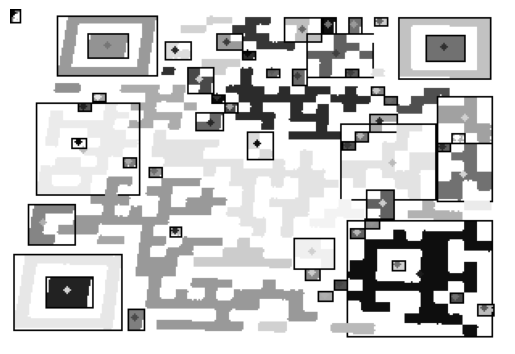

In [582]:
plt.imshow(output_image, "gray")
plt.axis("off")
plt.show()

# MEMORY MAP

In [583]:
print("Num centroid: {}".format(len(filtered_moments)))
for index, (moment, centroid)  in enumerate(zip(filtered_moments, filtered_centroids)):
    print("AREA: {}  {}  CENTROID: {}".format(index + 1, moment["m00"] , centroid))

Num centroid: 53
AREA: 1  23.0  CENTROID: [1, 2]
AREA: 2  933.0  CENTROID: [59, 22]
AREA: 3  195.0  CENTROID: [181, 12]
AREA: 4  73.0  CENTROID: [197, 9]
AREA: 5  76.0  CENTROID: [213, 9]
AREA: 6  40.0  CENTROID: [229, 7]
AREA: 7  930.0  CENTROID: [270, 23]
AREA: 8  349.0  CENTROID: [60, 22]
AREA: 9  117.0  CENTROID: [134, 20]
AREA: 10  372.0  CENTROID: [202, 27]
AREA: 11  383.0  CENTROID: [269, 23]
AREA: 12  128.0  CENTROID: [102, 25]
AREA: 13  39.0  CENTROID: [147, 27]
AREA: 14  160.0  CENTROID: [117, 43]
AREA: 15  38.0  CENTROID: [162, 38]
AREA: 16  75.0  CENTROID: [178, 41]
AREA: 17  40.0  CENTROID: [211, 39]
AREA: 18  40.0  CENTROID: [227, 50]
AREA: 19  37.0  CENTROID: [54, 54]
AREA: 20  39.0  CENTROID: [128, 54]
AREA: 21  40.0  CENTROID: [235, 56]
AREA: 22  472.0  CENTROID: [282, 67]
AREA: 23  39.0  CENTROID: [45, 60]
AREA: 24  1500.0  CENTROID: [45, 87]
AREA: 25  38.0  CENTROID: [136, 60]
AREA: 26  123.0  CENTROID: [124, 70]
AREA: 27  132.0  CENTROID: [229, 69]
AREA: 28  1040.0 

In [584]:
# Kết hợp moments, centroids và bounding_box vào một danh sách các tuple
combined = list(zip(filtered_moments, filtered_centroids, bounding_box))

# Sắp xếp danh sách theo moment['m00'] (diện tích)
sorted_combined = sorted(combined, key=lambda x: x[0]['m00'], reverse=False)

# In kết quả đã sắp xếp
print("Num centroid: {}".format(len(sorted_combined)))
for moment, centroid, box in sorted_combined:
    print("AREA: {}  CENTROID: {}  BOUNDING BOX: {}".format(moment['m00'], centroid, box))

Num centroid: 53
AREA: 23.0  CENTROID: [1, 2]  BOUNDING BOX: [0, 0, 6, 8]
AREA: 36.0  CENTROID: [102, 137]  BOUNDING BOX: [99, 135, 7, 6]
AREA: 37.0  CENTROID: [54, 54]  BOUNDING BOX: [51, 52, 8, 5]
AREA: 38.0  CENTROID: [162, 38]  BOUNDING BOX: [159, 37, 8, 5]
AREA: 38.0  CENTROID: [136, 60]  BOUNDING BOX: [133, 58, 8, 6]
AREA: 38.0  CENTROID: [277, 79]  BOUNDING BOX: [274, 77, 8, 6]
AREA: 39.0  CENTROID: [147, 27]  BOUNDING BOX: [144, 26, 8, 5]
AREA: 39.0  CENTROID: [128, 54]  BOUNDING BOX: [125, 53, 8, 5]
AREA: 39.0  CENTROID: [45, 60]  BOUNDING BOX: [42, 58, 8, 5]
AREA: 39.0  CENTROID: [42, 82]  BOUNDING BOX: [38, 80, 9, 6]
AREA: 39.0  CENTROID: [209, 84]  BOUNDING BOX: [206, 82, 8, 5]
AREA: 40.0  CENTROID: [229, 7]  BOUNDING BOX: [226, 5, 8, 5]
AREA: 40.0  CENTROID: [211, 39]  BOUNDING BOX: [208, 37, 8, 5]
AREA: 40.0  CENTROID: [227, 50]  BOUNDING BOX: [224, 48, 8, 5]
AREA: 40.0  CENTROID: [235, 56]  BOUNDING BOX: [232, 54, 8, 5]
AREA: 40.0  CENTROID: [268, 85]  BOUNDING BOX: [265

In [585]:
def is_within_bounding_box(ra, rc):

    print(ra, rc)
    ra_left = ra[0]
    ra_right = ra[0] + ra[2]
    ra_top = ra[1] 
    ra_bottom = ra[1] + ra[3] 

    rc_left = rc[0]
    rc_right = rc[0] + rc[2]
    rc_top = rc[1] 
    rc_bottom = rc[1] + rc[3] 
    
    print(ra_left, ra_right, ra_top, ra_bottom)
    print(rc_left, rc_right, rc_top, rc_bottom)
    res =  (ra_left >= rc_left and ra_right <= rc_right 
            and ra_top >= rc_top and ra_bottom <= rc_bottom)
    print(res)
    return res
          

In [586]:
def find_similar_centroids(centroids, areas, bounding_box, centroid_tolerance=3, area_ratio_threshold=4):
    """Tìm các cặp vùng có centroid gần nhau và kiểm tra các điều kiện diện tích."""
    regions = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            centroid_ra = centroids[i]
            centroid_rc = centroids[j]
            area_ra = areas[i]["m00"]
            area_rc = areas[j]["m00"]
            print("RA RC {} {}".format(area_ra, area_rc) )
            # Kiểm tra điều kiện diện tích và tỷ lệ diện tích
            print("RC/RA {}".format(area_rc / area_ra))
            if area_rc > area_ra and (area_rc / area_ra) <= area_ratio_threshold and (area_rc / area_ra) >= 1.333:
                # print("RA RC {} {}".format(area_ra, area_rc) )
                # # Kiểm tra điều kiện diện tích và tỷ lệ diện tích
                # print("RC/RA {}".format(area_rc / area_ra))
                # # Tính khoảng cách giữa hai centroid
                dist_centroid = np.sqrt((centroid_rc[0] - centroid_ra[0]) ** 2 + (centroid_rc[1] - centroid_ra[1]) ** 2)
                print(dist_centroid)
                bounding_box_ra = bounding_box[i]
                bounding_box_rc = bounding_box[j]
                if is_within_bounding_box(bounding_box_ra, bounding_box_rc):
                    regions.append([i, j]) 
            print("--------------------")
    print("FOUND ", regions)
    return regions

In [587]:
moments_list, centroids_list, bounding_box_list = zip(*sorted_combined)
print(moments_list)
print(centroids_list)
print(bounding_box_list)

({'m00': 23.0, 'm10': 38.0, 'm01': 65.0, 'm20': 114.0, 'm11': 70.0, 'm02': 277.0, 'm30': 410.0, 'm21': 154.0, 'm12': 246.0, 'm03': 1397.0, 'mu20': 51.21739130434783, 'mu11': -37.391304347826086, 'mu02': 93.30434782608695, 'mu30': 52.41209829867674, 'mu21': -44.62003780718339, 'mu12': -0.3100189035916302, 'mu03': 86.80151228733463, 'nu20': 0.09681926522561027, 'nu11': -0.07068299498643872, 'nu02': 0.17637872934988083, 'nu30': 0.020659126590265378, 'nu21': -0.017587752435858917, 'nu12': -0.00012219926281479304, 'nu03': 0.034214303353235456}, {'m00': 36.0, 'm10': 3674.0, 'm01': 4935.0, 'm20': 375096.0, 'm11': 503650.0, 'm02': 676585.0, 'm30': 38309984.0, 'm21': 51420600.0, 'm12': 69050870.0, 'm03': 92770125.0, 'mu20': 143.8888888889353, 'mu11': 5.833333333395672, 'mu02': 78.75000000009351, 'mu30': -15.987654325486501, 'mu21': -0.6481481537646906, 'mu12': 12.638888878349626, 'mu03': 7.291666647572252, 'nu20': 0.11102537722911673, 'nu11': 0.004501028806632462, 'nu02': 0.06076388888896104, '

In [588]:
found_regions = find_similar_centroids(centroids_list, moments_list, bounding_box_list)[:3]

RA RC 23.0 36.0
RC/RA 1.565217391304348
168.6001186239203
[0, 0, 6, 8] [99, 135, 7, 6]
0 6 0 8
99 106 135 141
False
--------------------
RA RC 23.0 37.0
RC/RA 1.608695652173913
74.24957912338628
[0, 0, 6, 8] [51, 52, 8, 5]
0 6 0 8
51 59 52 57
False
--------------------
RA RC 23.0 38.0
RC/RA 1.6521739130434783
164.97575579460153
[0, 0, 6, 8] [159, 37, 8, 5]
0 6 0 8
159 167 37 42
False
--------------------
RA RC 23.0 38.0
RC/RA 1.6521739130434783
146.93195704134618
[0, 0, 6, 8] [133, 58, 8, 6]
0 6 0 8
133 141 58 64
False
--------------------
RA RC 23.0 38.0
RC/RA 1.6521739130434783
286.5397005652096
[0, 0, 6, 8] [274, 77, 8, 6]
0 6 0 8
274 282 77 83
False
--------------------
RA RC 23.0 39.0
RC/RA 1.6956521739130435
148.12494725737457
[0, 0, 6, 8] [144, 26, 8, 5]
0 6 0 8
144 152 26 31
False
--------------------
RA RC 23.0 39.0
RC/RA 1.6956521739130435
137.23337786413333
[0, 0, 6, 8] [125, 53, 8, 5]
0 6 0 8
125 133 53 58
False
--------------------
RA RC 23.0 39.0
RC/RA 1.6956521739130435


In [589]:
print(found_regions)

[[41, 48], [43, 47], [45, 50]]


In [590]:
for item in found_regions:
    print(bounding_box_list[item[0]], bounding_box_list[item[1]])

[48, 15, 25, 15] [29, 4, 62, 37]
[258, 16, 24, 16] [241, 5, 57, 38]
[22, 166, 29, 19] [2, 152, 67, 47]


In [591]:
from qr_patterns import FinderPattern
pattern_info: List[FinderPattern] = []
for item in found_regions:
        ra = moments_list[item[0]]
        rc = moments_list[item[1]]
        dividor = ra["m00"] + rc["m00"]
        C_x = int((ra["m10"] +  rc["m10"]) / dividor)
        C_y = int((ra["m01"] + rc["m01"]) / dividor)
        mw = ((ra["m00"] + rc["m00"]) / 33)**0.5
        finder_pattern = FinderPattern(C_x, C_y, mw)
        pattern_info.append(finder_pattern)
        print(f"Centroid {(C_x, C_y)} , Module Estimate {mw}")


Centroid (59, 22) , Module Estimate 6.232855272544426
Centroid (269, 23) , Module Estimate 6.3077633744362025
Centroid (35, 175) , Module Estimate 7.269696338120655


In [592]:
img_result = image_crop.copy()

# Vẽ bounding box lên ảnh
for index, item in enumerate(found_regions):
    for i in range(0,2):
        x, y, w, h = bounding_box_list[item[i]]
        # Vẽ một hình chữ nhật (bounding box)
        cv2.rectangle(img_result, (x, y), (x + w, y + h), (255, 0, 0), 1)
    # Vẽ điểm lên ảnh
    cv2.circle(img_result, (pattern_info[index].get_x(), pattern_info[index].get_y()), 3, (0, 255, 0), -1)  # (0, 0, 255) là màu đỏ, -1 có nghĩa là tô đầy


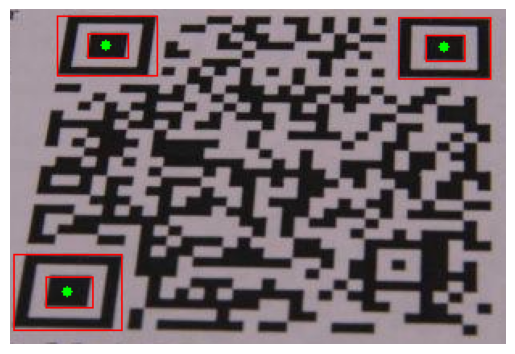

In [593]:
plt.imshow(img_result)
plt.axis("off")
plt.show()

In [594]:
from qr_patterns import ResultPoint, FinderPatternInfo
ResultPoint.order_best_patterns(pattern_info)
finder_pattern_info = FinderPatternInfo(pattern_info)

In [595]:
top_left = finder_pattern_info.get_top_left()
top_right = finder_pattern_info.get_top_right()
bottom_left = finder_pattern_info.get_bottom_left()

print(top_left.get_x(), top_left.get_y())
print(top_right.get_x(),top_right.get_y())
print(bottom_left.get_x(), bottom_left.get_y())

59 22
269 23
35 175


In [596]:
def normalize_vector(vector):
    magnitude = math.sqrt(vector[0] ** 2 + vector[1] ** 2)
    return [vector[0] / magnitude, vector[1] / magnitude] if magnitude != 0 else [0, 0]

In [597]:
tl_x = top_left.get_x()
tl_y = top_left.get_y()
tr_x = top_right.get_x()
tr_y = top_right.get_y()
bl_x = bottom_left.get_x()
bl_y = bottom_left.get_y()

vector_tr_bl = [bl_x - tr_x, bl_y - tr_y]
normalized_tr_bl = normalize_vector(vector_tr_bl)
bl_corner_x = bl_x + normalized_tr_bl[0] * bottom_left.get_estimated_module_size() * math.sqrt(18)
bl_corner_y = bl_y + normalized_tr_bl[1] * bottom_left.get_estimated_module_size() * math.sqrt(18)

vector_bl_tr = [tr_x - bl_x, tr_y - bl_y]
normalized_bl_tr = normalize_vector(vector_bl_tr)
tr_corner_x = tr_x + normalized_bl_tr[0] * top_right.get_estimated_module_size() * math.sqrt(18)
tr_corner_y = tr_y + normalized_bl_tr[1] * top_right.get_estimated_module_size() * math.sqrt(18)

est_qr_center = [(tr_x + bl_x) / 2, (tr_y + bl_y) / 2]
vector_center_tl = [tl_x - est_qr_center[0], tl_y - est_qr_center[1]]
normalized_center_tl = normalize_vector(vector_center_tl)
tl_corner_x = tl_x + normalized_center_tl[0] * top_left.get_estimated_module_size() * math.sqrt(18)
tl_corner_y = tl_y + normalized_center_tl[1] * top_left.get_estimated_module_size() * math.sqrt(18)


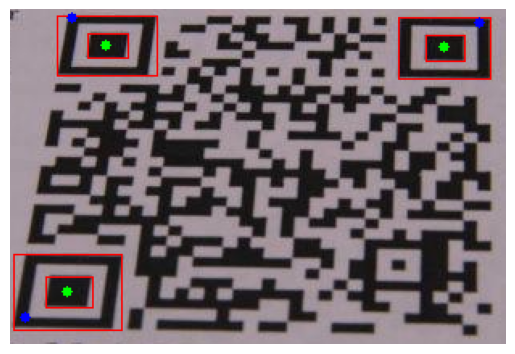

In [598]:
cv2.circle(img_result, (int(tl_corner_x), int(tl_corner_y)), 3, (0, 0, 255), -1)  
cv2.circle(img_result, (int(tr_corner_x), int(tr_corner_y)), 3, (0, 0, 255), -1)  
cv2.circle(img_result, (int(bl_corner_x), int(bl_corner_y)), 3, (0, 0, 255), -1)  

plt.imshow(img_result)
plt.axis("off")
plt.show()

In [599]:
br_corner_x = tr_corner_x + bl_corner_x - tl_corner_x
br_corner_y = tr_corner_y + bl_corner_y - tl_corner_y
print(br_corner_x, br_corner_y)

261.9459461449613 195.0873162021626


In [600]:
# cv2.circle(img_result, (int(br_corner_x), int(br_corner_y)), 3, (0, 0, 255), -1)  

# plt.imshow(img_result)
# plt.axis("off")
# plt.show()

In [601]:
line_tl_bl_a = (bl_corner_y - tl_corner_y) / (bl_corner_x - tl_corner_x) 
line_tl_bl_b = -1 
line_tl_bl_c =  - tr_corner_y + ((bl_corner_y - tl_corner_y) / (bl_corner_x - tl_corner_x)) * tr_corner_x

line_tl_tr_a = (tr_corner_y - tl_corner_y) / (tr_corner_x - tl_corner_x)
line_tl_tr_b = -1
line_tl_tr_c = - bl_corner_y + ((tr_corner_y - tl_corner_y) / (tr_corner_x - tl_corner_x)) * bl_corner_x

A = np.array([[line_tl_bl_a , line_tl_bl_b], [line_tl_tr_a, line_tl_tr_b]])
B = np.array([line_tl_bl_c, line_tl_tr_c])
print(A)
print(B)
solution = np.linalg.solve(A, B)
print(solution)


[[    -6.3284          -1]
 [   0.012999          -1]]
[    -1852.8     -191.68]
[     261.95      195.09]


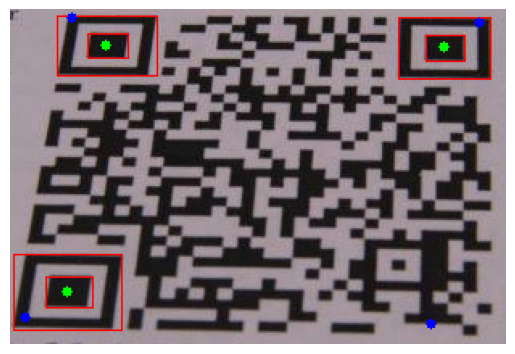

In [602]:
cv2.circle(img_result, (int(solution[0]), int(solution[1])), 3, (0, 0, 255), -1)  

plt.imshow(img_result)
plt.axis("off")
plt.show()

In [603]:
def calculate_phe(image):
    """
    Tính PHE (Prediction of Horizontal Edges) cho một hình ảnh.
    
    Args:
        image: numpy.ndarray, hình ảnh grayscale (2D array).
    
    Returns:
        phe: numpy.ndarray, chuỗi giá trị PHE cho từng hàng.
    """
    # Kiểm tra ảnh đầu vào có phải ảnh xám hay không
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale (2D array).")
    
    height, width = image.shape
    phe = np.zeros(height)
    
    # Tính PHE (Prediction of Horizontal Edges)
    for y in range(height):
        for x in range(width - 1):
            phe[y] += abs(int(image[y, x + 1]) - int(image[y, x]))
    
    return phe


In [604]:
def calculate_pve(image):
    """
    Tính PVE (Prediction of Vertical Edges) cho một hình ảnh.
    
    Args:
        image: numpy.ndarray, hình ảnh grayscale (2D array).
    
    Returns:
        pve: numpy.ndarray, chuỗi giá trị PVE cho từng cột.
    """
    # Kiểm tra ảnh đầu vào có phải ảnh xám hay không
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale (2D array).")
    
    height, width = image.shape
    pve = np.zeros(width)
    
    # Tính PVE (Prediction of Vertical Edges)
    for x in range(width):
        for y in range(height - 1):
            pve[x] += abs(int(image[y + 1, x]) - int(image[y, x]))
    
    return pve

In [605]:
est_module_overall = (top_left.get_estimated_module_size() + top_right.get_estimated_module_size() + bottom_left.get_estimated_module_size()) / 3
print(f"Overall Estimate Module {est_module_overall}")

Overall Estimate Module 6.603438328367095


In [606]:
if est_module_overall >= 2:
    step = 2
else:
    step = 1
vector_br_tr_x = tr_corner_x - solution[0]
vector_br_tr_y = tr_corner_y - solution[1]
distance_br_tr = math.sqrt(vector_br_tr_x **2 + vector_br_tr_y**2)

current_x = solution[0]
current_y = solution[1]
std = 0 

while step <= 0.5:
    while math.sqrt((current_x - tr_corner_x) ** 2 + (current_y - tr_corner_y) ** 2) >= est_module_overall:
        temp_x = current_x + (vector_br_tr_x / distance_br_tr) * est_module_overall * step
        temp_y = current_y + (vector_br_tr_y / distance_br_tr) * est_module_overall * step
        
        

